In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [594]:
seed =10
N = 1000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 10
dt = 0.1
t = np.arange(0,10000,dt)
K = 6
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

(1.0, 595.35)

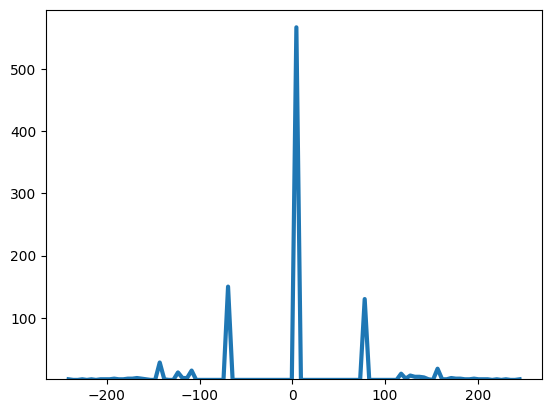

In [595]:
th = ((theta[-1] - theta[-5000] )//(np.pi*2))
c,b = np.histogram(th,bins=100)
plt.plot(b[1:],c,lw=3)
plt.ylim(1,)

In [447]:
def Get_Group(TH_s,TH_e,L,dt):
    ARG = (TH_s-TH_e)//(2*np.pi)
    ARG =  np.where(ARG<0,ARG,ARG)
    u,c = np.unique(ARG,return_counts=True)

    I_c_o1 =np.where(c>5)
    u_o1 = u[I_c_o1]
    c_o1 = c[I_c_o1]
    u_c = np.argsort(c_o1)[::-1]
    UU = u_o1[u_c]

    arr = UU
    main_value = np.min(abs(arr))
    adjusted_arr = arr - main_value
    abs_arr = np.unique(np.abs(adjusted_arr))
    abs_arr
    group_threshold = 5
    G = {}
    GP = {}
    GM = {}
    GN = {}
    G_num = 0
    GP_num = 1
    GM_num = 1
    I_num = 1
    for i in range(1,5):
        GP[i,'I'] = []
        GP[i,'R'] = np.nan
        GP[i,'L'] = np.nan
        GP[i,'V'] = np.nan
        GM[i,'I'] = []
        GM[i,'R'] = np.nan
        GM[i,'L'] = np.nan
        GM[i,'V'] = np.nan
    for i in range(5):
        abs_arr = np.unique(np.abs(adjusted_arr))
        for num in abs_arr:
            abs_adjust_arr = np.abs(adjusted_arr)
            in_group = np.int64(np.round((abs_adjust_arr-num)/group_threshold)) * group_threshold
            is_group = np.where(abs(in_group) < 1)
            not_group = np.where(in_group >= 1)
            if len(is_group) != 0:
                Ra_arr = adjusted_arr[is_group]
                R = Ra_arr + main_value
                if G_num == 0:
                    I, = np.where(np.isin(ARG,R))
                    G[G_num,'I'] = I
                    G[G_num,'R'] = R
                    G[G_num,'L'] = len(I)
                    G[G_num,'V'] = np.mean(R/(L-1)/dt)
                    G_num +=1
                else:
                    gp_idx, = np.where(Ra_arr>0)
                    gm_idx, = np.where(Ra_arr<0)
                    Rp = R[gp_idx]
                    Rm = R[gm_idx]
                    Ip, = np.where(np.isin(ARG,Rp))
                    Im, = np.where(np.isin(ARG,Rm))
                    if (len(Rp) !=0) and (len(Rm) != 0):
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                        GM[GM_num,'L'] = len(Im)
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                        GP[GP_num,'L'] = len(Ip)
                        GP_num += 1
                        GM_num += 1
                    elif (len(Rp) !=0):
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'L'] = len(Ip)
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)

                        GP_num += 1
                    else:
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'L'] = len(Im)
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)

                        GM_num += 1

            adjusted_arr = adjusted_arr[not_group]
            break
    return G,GM,GP

# cluster check
이상하게 겹쳐있는 데이터는 없에야 함
그렇다면 어떤 조건을 가지고 이걸 제거 할 수 있을까?
3개의 변화가 생각보다 작아야 함

626
143
84
13
8
11
3


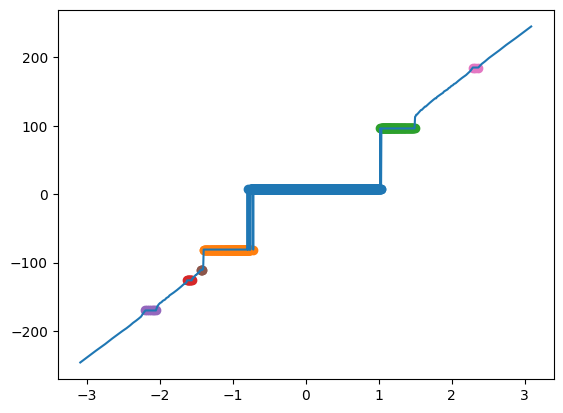

In [448]:
un,ui,uc = np.unique(th,return_index=True,return_counts=True,)
uci = np.argsort(uc)
plt.plot(omega,th)
for i in un[uci][:-8:-1]:
    X, = np.where(th==i)
    th = np.where(np.abs(th-i)<5,i,th)
    plt.scatter(omega[X],th[X],label=f'{i},{len(X)}')
    

    # print(np.unique(np.diff(X),return_counts=True))

# un,ui,uc = np.unique(th,return_index=True,return_counts=True,)
# uct, = np.where(uc>TH)
# un,ui,uc = un[uct],ui[uct],uc[uct]
# uci = np.argsort(uc)

for i in un[uci][:-8:-1]:
    X, = np.where(th==i)
    print(len(X))
    # plt.scatter(X,th[X],label=f'{i},{len(X)}')
    # print(np.unique(np.diff(X),return_counts=True))


In [449]:
TH = 10000
TH_S,TH_E,L = theta[-1],theta[-TH],TH
G,GM,GP = Get_Group(TH_S,TH_E,L,dt =dt)

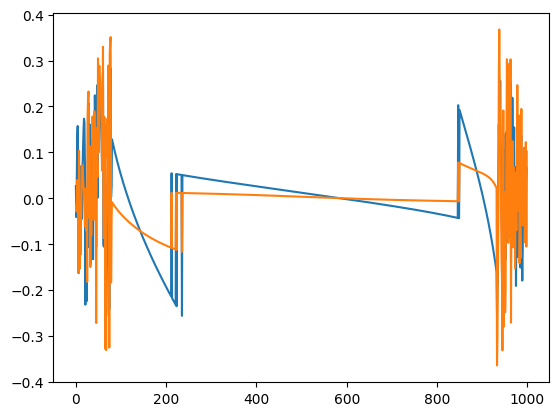

In [450]:
plt.plot(dtheta[-1]-dtheta[-1000])
plt.plot(dtheta[-1]-dtheta[-4000])


In [451]:
def get_indx(th,rs,N,t_idx): 
    th = np.where(th>=0,th,th+1)
    th = th/(t[-1] - t[-t_idx])
    c,b = np.histogram(th,bins=100)
    c_sort = np.sort(c)[::-1]
    c_3 = np.where(c_sort>np.max(c)*(0.05))
    print(np.max(c)/50)
    c_arg = np.argsort(c)[::-1]
    b_n0 = b[c_arg[c_3]]
    db = b[1] - b[0]
    gs = {}
    gs['group #'] = []
    gs['group rot'] = []
    gs['group idx'] = []
    if np.mean(rs)>1/np.sqrt(N):
        for b_l in b_n0:
            idx, = np.where((th>=b_l)&(th<=b_l+db))
            print(np.std(th[idx]))
            gs['group idx'].append(idx)
            gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
            gs['group #'].append(len(idx))
    return pd.DataFrame(gs)


In [452]:
th = (theta[-1] - theta[-1000])//(np.pi*2)
t_idx = 2000
th = (theta[-1] - theta[-t_idx])//(np.pi*2)
df_g = get_indx(th,rs[-500:],N,t_idx)

12.52
0.0
2.7755575615628914e-17
2.7755575615628914e-17


In [453]:
ths = [(dtheta[-1-i]-dtheta[-1000-i]) for i in range(1000)]
ths = np.array(ths)
sths = np.mean(ths, axis=0)


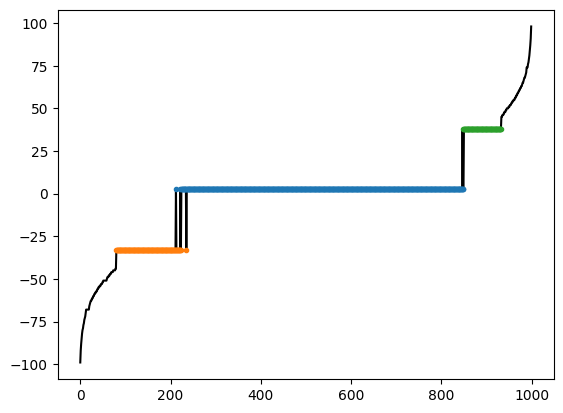

In [454]:
for idx in df_g['group idx']:
    plt.scatter(idx,th[idx],marker='.',zorder=3)
plt.plot(th,color='black')

In [455]:
df_g['group abs rot'] = (df_g['group rot']-(df_g['group rot'].iloc[0]+df_g['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
if abs(df_g['group rot'].iloc[0])<0.1:
    print('asdfadfs')
    df_g['group abs rot'] = (df_g['group rot']-(df_g['group rot'].iloc[0])).apply(lambda x: np.abs(x))
else:
    df_g['group abs rot'] = (df_g['group rot']-(df_g['group rot'].iloc[0]+df_g['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))

asdfadfs


In [456]:
def assign_group_by_tolerance(df, tolerance):
    group_number = 0
    current_group_start = df['group abs rot'][0]  # 첫번째 값이 그룹의 시작 기준
    print(current_group_start)
    # 첫번째 값에 그룹 번호 할당
    df.at[0, 'Group'] = group_number
    
    # 두번째 값부터 확인하면서 그룹을 할당
    for i in range(1, len(df)):
        # 현재 값이 그룹 시작 값으로부터 tolerance 안에 있으면 같은 그룹으로 묶음
        if df['group abs rot'][i] - current_group_start <= tolerance:
            print(current_group_start,df['group abs rot'][i])
            df.at[i, 'Group'] = group_number
        else:
            # 그룹 시작 값보다 tolerance를 벗어나면 새로운 그룹을 할당
            group_number += 1
            current_group_start = df['group abs rot'][i]  # 새로운 그룹 시작 값 갱신
            df.at[i, 'Group'] = group_number

    return df

In [457]:
group_number = 0
df = df_g.sort_values(by='group abs rot').reset_index(drop=True)
df
df = assign_group_by_tolerance(df,0.1)

0.0
1.1001074824976682 1.1001074824976687


In [458]:
df['g sign'] = np.sign(df['group rot']) * np.sign(df['group abs rot'])

In [469]:
total_memory = df.memory_usage(deep=True).sum()
print(f"Total memory usage: {total_memory/2**20} mb")

Total memory usage: 0.11541366577148438 mb


In [460]:
def S_rho(x):
    L = len(x)
    N = len(theta[-1])
    a = theta[-5000:,x]
    ST = np.sum(np.exp(a*1j),axis=1)
    rho = np.abs(ST/L)
    return rho

def rhos(x):
    L = len(x)
    a = theta[:,x]
    ST = np.sum(np.exp(a*1j),axis=1)
    rho = np.abs(ST/L)
    return rho


In [461]:
df['group idx'].apply(g_r)

0    ([0.9890037268316755, 0.9890012853214127, 0.98...
1    ([0.963994789235746, 0.9638171542419208, 0.963...
2    ([0.9763488114572642, 0.9763944449167529, 0.97...
Name: group idx, dtype: object

In [462]:
df['rho_s'] = df['group idx'].apply(S_rho)
df['r_m'] = df['rho_s'].apply(np.mean) * df['group #']/N
df['r_std'] = df['rho_s'].apply(np.std) * df['group #']/N

In [473]:
a = df['rho_s'][1]*df['group #'][1]/N

In [477]:
df['r_std']

0    0.001257
1    0.001539
2    0.002123
Name: r_std, dtype: float64

In [476]:
np.std(a)

0.0015389624935840394

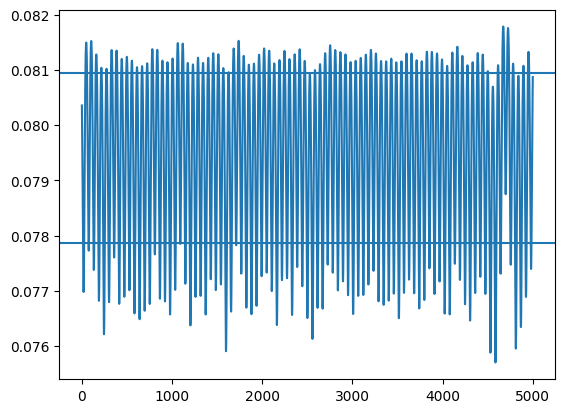

In [475]:
plt.plot(a)
plt.axhline(np.mean(a)+np.std(a))
plt.axhline(np.mean(a)-np.std(a))

In [463]:
plt.plot(df['rho_s'][0])
plt.plot(df['rho_s'][0])

,group #,group rot,group idx,group abs rot,Group,g sign,rho_s,r_m,r_std
0,626,0.094295,"[212, 222, 224, 225, 226, 227, 228, 229, 230, ...",0.000000,0.0,0.0,"[0.9880774620308596, 0.9878238218851068, 0.987...",0.617654,0.001257
1,84,1.194402,"[847, 850, 851, 852, 853, 854, 855, 856, 857, ...",1.100107,1.0,1.0,"[0.9566048204170482, 0.9549520587870842, 0.953...",0.079402,0.001539
2,143,-1.005813,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",1.100107,1.0,-1.0,"[0.967053891623453, 0.9654023368866622, 0.9635...",0.136871,0.002123


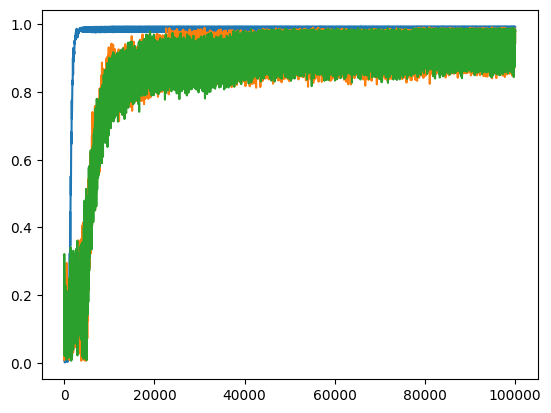

In [440]:
plt.plot( df['rho'][0])
plt.plot( df['rho'][1])
plt.plot( df['rho'][2])
# plt.xlim(0,10000)

In [470]:
df

,group #,group rot,group idx,group abs rot,Group,g sign,rho_s,r_m,r_std
0,626,0.094295,"[212, 222, 224, 225, 226, 227, 228, 229, 230, ...",0.000000,0.0,0.0,"[0.9880774620308596, 0.9878238218851068, 0.987...",0.617654,0.001257
1,84,1.194402,"[847, 850, 851, 852, 853, 854, 855, 856, 857, ...",1.100107,1.0,1.0,"[0.9566048204170482, 0.9549520587870842, 0.953...",0.079402,0.001539
2,143,-1.005813,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",1.100107,1.0,-1.0,"[0.967053891623453, 0.9654023368866622, 0.9635...",0.136871,0.002123


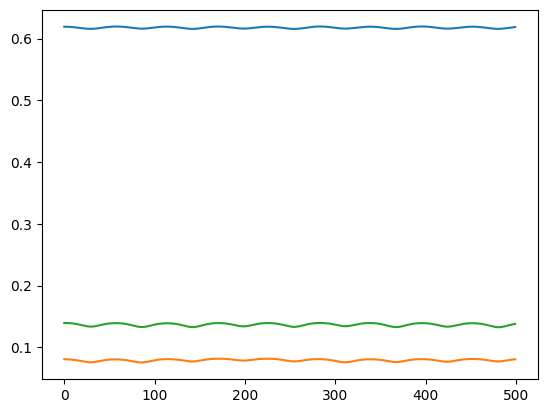

In [397]:
plt.plot(df['rho_c,r_c'][0][1])
plt.plot(df['rho_c,r_c'][1][1])
plt.plot(df['rho_c,r_c'][2][1])

In [252]:
a.sort_values(by='Group')['group abs rot']

0    0.000000
1    0.911518
2    0.942949
6    1.384957
5    1.407028
4    1.604863
8    1.634445
3    1.854467
7    1.854467
Name: group abs rot, dtype: float64

In [285]:
data = {'Value': [0.000000, 0.911518, 0.942949, 1.384957, 1.407028, 1.604863, 1.634445, 1.854467, 1.854467]}
df = pd.DataFrame(data)

# 우선 값들을 정렬
df = df.sort_values(by='Value').reset_index(drop=True)

# tolerance 값 설정 (0.1)
tolerance = 0.1

# 그룹 번호를 초기화
group_number = 0
df['Group'] = None

# 그룹 지정 함수
def assign_group_by_tolerance(df, tolerance):
    global group_number  # 그룹 번호를 외부에서 관리
    current_group_start = df['Value'][0]  # 첫번째 값이 그룹의 시작 기준
    
    # 첫번째 값에 그룹 번호 할당
    df.at[0, 'Group'] = group_number
    
    # 두번째 값부터 확인하면서 그룹을 할당
    for i in range(1, len(df)):
        # 현재 값이 그룹 시작 값으로부터 tolerance 안에 있으면 같은 그룹으로 묶음
        if df['Value'][i] - current_group_start <= tolerance:
            df.at[i, 'Group'] = group_number
        else:
            # 그룹 시작 값보다 tolerance를 벗어나면 새로운 그룹을 할당
            group_number += 1
            current_group_start = df['Value'][i]  # 새로운 그룹 시작 값 갱신
            print(current_group_start)

            df.at[i, 'Group'] = group_number

    return df
assign_group_by_tolerance(df,0.1)

0.911518
1.384957
1.604863
1.854467


,Value,Group
0,0.000000,0
1,0.911518,1
2,0.942949,1
3,1.384957,2
4,1.407028,2
5,1.604863,3
6,1.634445,3
7,1.854467,4
8,1.854467,4


In [231]:
c,b = np.histogram(df_g[['group abs rot']])
df_g['group'] = None
print(c)
i0,=np.where(c>0)
c0 = c[i0]
print(c0)
b_l,b_r = b[i0],b[i0+1]
for i,(l,r) in enumerate(zip(b_l,b_r)):
    df_g.loc[(l<=df_g['group abs rot'])&(df_g['group abs rot']<=r),'group'] = i

[1 0 0 0 1 1 0 2 2 2]
[1 1 1 2 2 2]


In [232]:
b_l

array([0.        , 0.74178676, 0.92723345, 1.29812683, 1.48357352,
       1.66902021])

In [233]:
df_g.sort_values(by='group')

,group #,group rot,group idx,group abs rot,group
0,536,0.000000,"[235, 236, 238, 239, 241, 242, 243, 244, 245, ...",0.000000,0
1,156,-0.911518,"[81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 9...",0.911518,1
2,146,0.942949,"[760, 762, 763, 764, 765, 766, 767, 768, 769, ...",0.942949,2
5,17,1.407028,"[919, 920, 921, 922, 923, 924, 925, 926, 927, ...",1.407028,3
6,16,-1.384957,"[63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...",1.384957,3
4,17,-1.604863,"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 5...",1.604863,4
8,13,1.634445,"[946, 947, 948, 949, 950, 951, 952, 953, 954, ...",1.634445,4
3,21,-1.854467,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...",1.854467,5
7,16,1.854467,"[963, 964, 965, 966, 967, 968, 969, 970, 971, ...",1.854467,5


In [169]:
df_g

,group #,group rot,group idx,group abs rot2,group abs rot,group
0,579,0.000000,"[218, 220, 223, 224, 225, 226, 227, 228, 229, ...",0.424327,0.000000,0
1,131,-0.848654,"[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...",0.424327,0.848654,0
2,116,0.911518,"[792, 798, 799, 800, 802, 804, 805, 807, 808, ...",1.335845,0.911518,1


array([[<Axes: title={'center': 'group abs rot2'}>]], dtype=object)

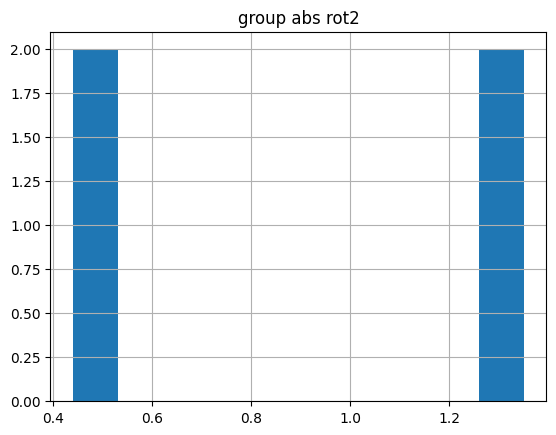

In [138]:
df_g[['group abs rot2']].hist()

In [387]:
for i in df_g[['group rot','group abs rot2','group abs rot']].values:
    print(i)

[-0.19440174  0.39580147  0.        ]
[0.5972012  0.39580147 0.79160295]
[1.41442391 1.21302418 1.60882565]
[-1.0372442   1.23864393  0.84284246]


# 통합환경 제작

In [671]:
def assign_group_by_tolerance(df, tolerance):
    group_number = 0
    current_group_start = df['group abs rot'][0]  # 첫번째 값이 그룹의 시작 기준
    # 첫번째 값에 그룹 번호 할당
    df.at[0, 'Group'] = group_number
    
    # 두번째 값부터 확인하면서 그룹을 할당
    for i in range(1, len(df)):
        # 현재 값이 그룹 시작 값으로부터 tolerance 안에 있으면 같은 그룹으로 묶음
        if df['group abs rot'][i] - current_group_start <= tolerance:
            df.at[i, 'Group'] = group_number
        else:
            # 그룹 시작 값보다 tolerance를 벗어나면 새로운 그룹을 할당
            group_number += 1
            current_group_start = df['group abs rot'][i]  # 새로운 그룹 시작 값 갱신
            df.at[i, 'Group'] = group_number

    return df

def Get_Group(theta,t,L):
    th = (theta[-1]-theta[-L])//(np.pi*2)
    r = np.mean(np.abs(np.mean(np.exp(1j*theta[-500:]),axis=1)))
    th = np.where(th>=0,th,th+1)
    th = th/(t[-1] - t[-L])
    c,b = np.histogram(th,bins=100)
    c_sort = np.sort(c)[::-1]
    c_3 = np.where(c_sort>np.max(c)*(0.05))
    c_arg = np.argsort(c)[::-1]
    b_n0 = b[c_arg[c_3]]
    db = b[1] - b[0]
    N = len(theta[-1])
    gs = {}
    gs['group #'] = []
    gs['group rot'] = []
    gs['group idx'] = []
    if r>1/np.sqrt(N):
        for b_l in b_n0:
            idx, = np.where((th>=b_l)&(th<=b_l+db))
            gs['group idx'].append(idx)
            gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
            gs['group #'].append(len(idx))
    df =  pd.DataFrame(gs)
    try:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
        if abs(df['group rot'].iloc[0])<0.2:
            df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0])).apply(lambda x: np.abs(x))
        else:
            df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
    except IndexError:
        df = pd.DataFrame()
        df[['group #','group rot','Group','g sign','r_m','r_std']] = None 
        return df
    df = df.sort_values(by='group abs rot').reset_index(drop=True)
    df = assign_group_by_tolerance(df,0.1)
    def S_rho(x):
        L = len(x)
        a = theta[-L:,x]
        ST = np.sum(np.exp(a*1j),axis=1)
        rho = np.abs(ST/L)
        return rho
    df['rho_s'] = df['group idx'].apply(S_rho)
    df['r_m'] = df['rho_s'].apply(np.mean) * df['group #']/N
    df['r_std'] = df['rho_s'].apply(np.std) * df['group #']/N
    df['g sign'] = np.sign(df['group rot']) * np.sign(df['group abs rot'])
    return df[['group #','group rot','Group','g sign','r_m','r_std']]

In [672]:
Get_Group(theta,t,2000)

,group #,group rot,Group,g sign,r_m,r_std
0,287,0.062863,0.0,0.0,0.565793,0.004429
1,81,-0.942949,1.0,-1.0,0.153870,0.005145
2,60,1.100107,1.0,1.0,0.114690,0.002409


In [673]:
from parfor import parfor
import TO_sim.Integrator_jit as IJ
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf,Kuramoto_1st_mf

RK4_jit_short = IJ.RK4_short

In [674]:
func = Kuramoto_2nd_mf

In [675]:
seed =11
N = 500
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 8
dt = 0.1
t = np.arange(0,10000,dt)
K = 5.1
L = 5000
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
# theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))
Theta = np.r_[theta_random,omega]
Ks = np.arange(0,10,0.2)

In [676]:
sol = RK4_jit_short(func,Theta,t, args=(omega, N, m, K),result_time=int(t[-6000]/dt))

In [677]:
theta = sol[:,:N]

In [678]:
(theta[-1] - theta[-5000]).shape

(500,)

In [679]:
r = np.mean(np.abs(np.mean(np.exp(1j*theta[-500:]),axis=1)))
r

0.5115898625322658

In [680]:
theta = sol[:,:N]
df = Get_Group(theta,t,L)

In [681]:
from tqdm.notebook import tqdm

In [682]:
@parfor(Ks,bar=True)
def K_f(K,L=5000):
    sol = RK4_jit_short(func,Theta,t, args=(omega, N, m, K),result_time=int(t[-5000]/dt))
    theta = sol[:,:N]
    df = Get_Group(theta,t,L)
    return df

  0%|          | 0/50 [00:00<?, ?it/s]

In [683]:
Ks = np.round(Ks,2)

In [684]:
Ks = np.round(Ks,2)
df_r = pd.DataFrame(index=np.round(Ks,2))
df_r[['0p','0m','0','1p','1m','2p','2m']] = None
for a,K in zip(K_f,Ks):
    for i in range(4):
        try:
            df_r.loc[K,f'{i}'] = a[(a['Group']==i)&(a['g sign']==0)]['r_m'].values[0]
        except:pass
        try:
            # print(a[(a['Group']==i)&(a['g sign']==1)]['r_m'].values[0])
            df_r.loc[K,f'{i}p'] = a[(a['Group']==i)&(a['g sign']==1)]['r_m'].values[0]
            df_r.loc[K,f'{i}m'] = a[(a['Group']==i)&(a['g sign']==-1)]['r_m'].values[0]
        except:pass



In [686]:
m

8

In [687]:
import TO_sim.analytical.order_sec_parameter as OSP
F_RMd2,F_RMu2,F_R0d2,F_R0u2 =  OSP.Make_R_function(m)
K_ = np.linspace(0,10,10000)

In [688]:
import numpy as np
import pandas as pd
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
from scipy.integrate import quad
from scipy.stats import norm
from numba import jit
from scipy import interpolate



def g_n(x):
    return norm.pdf(x,0,1)

def FX_lock1(X,m,g=g_n):
    # integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x))
    integrand_lock = lambda x:g(x)*np.sqrt(1-(x/X)**2)
    
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    
    A = omega_p/X
    I_l,err = quad(integrand_lock, -omega_p,omega_p,limit=200)
    return I_l/X

def FX_drift1(X,m,g=g_n):
    if m == 0:
        return 0
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)


    O_p = b*X
    # O_p = (4/np.pi)*np.sqrt(X/m)

    # integrand_drift = lambda x:1/(m*x**2+1/m)*g(x)
    integrand_drift = lambda x:1/(m*x**2+1/m)*g(x)
    I_d,err = quad(integrand_drift,O_p,np.inf,limit=200)
    return -1*I_d

def FX_0(X,m,O_0,g=g_n):
        O_d = min(O_0,X)
        theta_0 = np.arcsin(O_d/X)
        integrand_l = lambda x:np.cos(x)**2*g(X*np.sin(x))
        integrand_d = lambda x:(1/x**2)*g(x)
        I_l,err_l = quad(integrand_l,-theta_0,theta_0,limit=200) #lock
        I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift
        Fl = 1*I_l
        Fd = - 1/(m)*I_d
        F0 = Fl + Fd
        return F0,Fl,Fd
get_FX_l1 = np.vectorize(FX_lock1)
get_FX_d1 = np.vectorize(FX_drift1)
get_FX_0 = np.vectorize(FX_0)

def Make_R0_function(m,O_0,K_max=15,g_n=g_n):
    X = np.linspace((0.01),(20),num=3000)
    F0,Fl,Fd = get_FX_0(X,m,O_0,g=g_n)
    RX_l1 = X*Fl
    RX_d1 = X*Fd
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    if m == 0:
        F_RMd = F_RMu
        F_R0d = F_R0u
    else:
        F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
        F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)


    return F_RMd,F_RMu,F_R0d,F_R0u

def g_sec(x,Or,Om):
    g = norm.pdf(x,-Or,1)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

def get_O_r(r):
    r_s = np.linspace(r/2+0.5,1,5000,endpoint=False)
    A = norm.ppf(r_s)
    return np.mean(A)

def F_lock2(r,K,m,F_R0,F_RM,O_pm=None, g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

    r_0 = F_R0(K)
    if O_pm is None:
        O_pm = 4/np.pi*np.sqrt(K*F_RM(K)/m) - 0.3056/np.sqrt(K*F_RM(K)*m**3)
    # shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) -(K**2*r*r)/(2*m*(1/m**2+(2*O_pm)**2))
    shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) + (K**2*r*r)/(2*m**2*O_pm*(1/m**2+(2*O_pm)**2))
    integrand_lock = lambda x:g(x,O_pm-shift_O,O_pm)*np.sqrt(1-((x)/X)**2)
    omega_p = bs*X
    O_min = -shift_O - omega_p
    if O_min<0:
        m_ = O_min
    else:
        m_ = np.nan
        
    I_l,err = quad(integrand_lock, shift_O,+omega_p,limit=200)
    return I_l/X,m_
def F_drift2(r,K,m,F_R0,F_RM,O_pm=None,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)


    r_0 = F_R0(K)
    if O_pm is None:
        O_pm = 4/np.pi*np.sqrt(K*F_RM(K)/m) - 0.3056/np.sqrt(K*F_RM(K)*m**3)
    O_p = bs*X
    # shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) -(K**2*r*r)/(2*m*(1/m**2+(2*O_pm)**2))
    shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) + (K**2*r*r)/(2*m**2*O_pm*(1/m**2+(2*O_pm)**2))
    integrand_drift = lambda x:1/(2*(m*(x+O_pm-shift_O)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    # integrand_drift = lambda x:1/(2*(m*(x)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    # integrand_drift = lambda x:1/(2*(m*(x)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    # integrand_drift = lambda x:1/(2*x**2)*g(x+shift_O,O_r,O_pm)
    I_d,err = quad(integrand_drift,+O_p,np.inf,limit=200)
    # I_dm,err = quad(integrand_drift,-np.inf,-O_p,limit=200)
    return -1*(I_d)#+I_dm)

def F_sec(r,K,m,F_R0,F_RM,O_pm=None,g=g_sec):
    F_l2,m_ = F_lock2(r,K,m,F_R0,F_RM,O_pm,g)
    F_d2 = F_drift2(r,K,m,F_R0,F_RM,O_pm,g)
    return F_l2,F_d2,F_l2+F_d2,m_

get_Fp_l = np.vectorize(F_lock2)
get_Fp_d = np.vectorize(F_drift2)
get_F2 = np.vectorize(F_sec)
# get_F20 = np.vectorize(F_sec0)


def Make_R_function(m,K_max=15,g_n=g_n):
    X = np.linspace((0.01),(20),num=3000)
    RX_l1 = X*get_FX_l1(X,m,g=g_n)
    RX_d1 = X*get_FX_d1(X,m,g=g_n)
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    if m == 0:
        F_RMd = F_RMu
        F_R0d = F_R0u
    else:
        F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
        F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)

    return F_RMd,F_RMu,F_R0d,F_R0u

def get_r_sec(K,m,FR0,FRM,O_pm=None,samples=200,g_sec=g_sec):
    r0_ =  FR0(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    if (K == 0)or (m==0):
        return r_sd,r_su,r_su_d,r_su_l,md,mu
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F_l2,F_d2,F2,m_ = get_F2(r_test,K,m,FR0,FRM,O_pm)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    F2l_interpolate  = interpolate.interp1d(r_test,F_l2, kind='linear',bounds_error=False)
    m_interpolate  = interpolate.interp1d(r_test,m_, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    f_su = F2l_interpolate(r_su)
    f_sd = F2l_interpolate(r_sd)
    mu = m_interpolate(r_su)
    md = m_interpolate(r_sd)
    r_su_l = r_su*K*f_su
    r_sd_l = r_sd*K*f_sd
    return r_sd,r_su,r_sd_l,r_su_l,md,mu

# def get_r_sec0(K,r_last,shift_O,m,O_0,O_20,FR,samples=200):
#     r0_ =  FR(K)
#     r_sd,r_su = np.nan,np.nan
#     r_sd_l,r_su_l = np.nan,np.nan
#     mu = np.nan
#     md = np.nan
#     if (K == 0)or (m==0):
#         return r_sd,r_su,r_sd_l,r_su_l
#     r_test = np.linspace(1e-5,(1-r0_)/2,samples)
#     F2,Fl,Fd = get_F20(r_test,r_last,K,shift_O,m,O_0,O_20,FR)
#     R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
#     Rl_interpolate  = interpolate.interp1d(r_test,Fl, kind='linear',bounds_error=False)
#     r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
#     Fs = R2_interpolate(r_test2)
#     Fls = Rl_interpolate(r_test2)
#     cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
#     arg_check, = np.where(cross_point)

#     r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
#     F_ls = (Fls[arg_check] +Fls[arg_check+1])/2
#     if len(r_sec)>=3:
#         r_su = r_sec[-1]
#         r_su_l = F_ls[-1]*K*r_su
#     if len(r_sec)==2:
#         r_sd,r_su = r_sec
#         r_sd_l,r_su_l = F_ls[0]*K*r_sd,F_ls[1]*K*r_su

#     if len(r_sec)==1:
#         r_su = r_sec
#         r_su_l = F_ls*K*r_su
#     return r_sd,r_su,r_sd_l,r_su_l

get_r_sec_np = np.vectorize(get_r_sec)
# get_r_sec0_np = np.vectorize(get_r_sec0)


### GET O_R
def get_shift(O_0):
    r_last = norm.cdf(O_0)
    O_samples = np.linspace(O_0,4,1000)
    r_ = norm.cdf(O_samples)
    def get_O_r(r):
        r_s = np.linspace(r_last,r,10000,endpoint=False)
        A = norm.ppf(r_s)
        O_r = np.mean(A)
        shift_O = O_r - O_0
        return O_r,shift_O
    FO_r = np.vectorize(get_O_r)
    O_rs,shift_Os = FO_r(r_)
    Ops = O_samples-O_rs
    F_shift  = interpolate.interp1d(Ops,shift_Os, kind='linear',bounds_error=False)
    F_OR  = interpolate.interp1d(O_samples,O_rs, kind='linear',bounds_error=False)

    return F_shift,F_OR

def F_sec0(r,K,m,O_0,O_20,F_R0,F_S,F_OR,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    r_0 = F_R0(K)
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)
    a0 = 1/np.sqrt(K*r_0*m)

    O_pm = O_0
    shift_O = (K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) - (K**2*r*r)/(2*m**2*O_pm*(1/m**2+(2*O_pm)**2))#K**2 * r_0 * r/(2*m*(1/m**2+(O_0)**2)) + K**2 * r * r/(2*m*(1/m**2+(2*O_0)**2))

    shift_temp = F_S(X-shift_O)
    MAX = O_0+shift_temp+X
    # if MAX<O_20:
        # shift_temp = F_S(X)
        # O_20 = MAX
    OM = -shift_temp
    OP = min(O_20-O_0-shift_temp,X)
    
    if X<shift_temp:
        OM = 0
        OP = 0
    
    integrand_drift = lambda x:1/(2*(m*(x+shift_O)**2+1/m))*g(x,O_pm+shift_O,O_pm)
    integrand_lock = lambda x:g(x,O_pm+shift_temp,O_pm)*np.sqrt(1-((x)/X)**2)

    I_d,err = quad(integrand_drift,OP,np.inf,limit=200)
    I_l,err = quad(integrand_lock,OM ,OP,limit=200)
    
    return I_l/X-I_d,I_l/X,-I_d,shift_temp
get_F20 = np.vectorize(F_sec0)

def get_r_sec0(K,m,O_0,O_20,FR,F_S,F_OR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_sd_l,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    shift_Os = np.nan
    if (K == 0)or (m==0):
        return r_sd,r_su,r_sd_l,r_su_l
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2,Fl,Fd,shift_Os = get_F20(r_test,K,m,O_0,O_20,FR,F_S,F_OR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    Rl_interpolate  = interpolate.interp1d(r_test,Fl, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    Fls = Rl_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    F_ls = (Fls[arg_check] +Fls[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
        r_sd_l,r_su_l = F_ls[0]*K*r_sd,F_ls[1]*K*r_su

    if len(r_sec)==1:
        r_su = r_sec
        r_su_l = F_ls*K*r_su


    return r_sd,r_su,r_sd_l,r_su_l
get_r_sec0_np = np.vectorize(get_r_sec0)

def get_shift_O(r0,rp,O_O,K,m):
    shift = (K**2*r0*rp)/(2*m*(1/m**2+(O_O)**2)) - (K**2*rp*rp)/(2*m**2*O_O*(1/m**2+(2*O_O)**2))
    return shift


def get_OPM(RM,K,m):
    OPM =  4/np.pi*np.sqrt(K*RM/m) - 0.3056/np.sqrt(K*RM*m**3)
    return OPM

get_FX_0 = np.vectorize(FX_0)

In [691]:
import numpy as np
import scipy.integrate as si
from numba import cfunc, carray, jit
import numba
from numba.types import intc, CPointer, float64
from scipy import LowLevelCallable
from scipy.stats import norm
from numba import njit, prange
from scipy.integrate import quad

from numba import njit
import numpy as np

@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

def jit_integrand_function(integrand_function):
    jitted_function = numba.jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = numba.jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@jit_integrand_function
def integrand_l(x, X):
    return np.cos(x)**2*g(X*np.sin(x),0,1)
@jit_integrand_function
def integrand_d(x,X):
    return (1/x**2)*g(x,0,1)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)
    

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm-shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return 1/(2*(m*(x+O_pm-shift_O)**2+1/m))*g_sec(x,O_pm-shift_O,O_pm)


def FX_0(X,m,O_0):
    O_d = min(O_0,X)
    theta_0 = np.arcsin(O_d/X)
    I_l,err_l = quad(integrand_l,-theta_0,theta_0,limit=200) #lock
    I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift
    Fl = 1*I_l
    Fd = - 1/(m)*I_d
    F0 = Fl + Fd
    return F0,Fl,Fd
get_FX_0 = np.vectorize(FX_0)

def FX_Rld(X,m,O_0):
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,O_0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,O_0,1,m),limit=200)
    R_dl,err = quad(integrand_Rd,-np.inf,-omega_p,args=(X,O_0,1,m),limit=200)

    R_d = R_dr +  R_dl
    R = R_l - R_d
    return R_l,-R_d,R

get_FX_Rld = np.vectorize(FX_Rld)

def Make_R_function(m,O_0,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    RX_l1,RX_d1,RX_F = get_FX_Rld(X,m,O_0)
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    if m == 0:
        F_RMd = F_RMu
        F_R0d = F_R0u
    else:
        F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
        F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)

    return F_RMd,F_RMu,F_R0d,F_R0u



def F_sec(r,K,m,F_R0,F_RM,O_pm=None, g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

    r_0 = F_R0(K)
    if O_pm is None:
        O_pm = 4/np.pi*np.sqrt(K*F_RM(K)/m) - 0.3056/np.sqrt(K*F_RM(K)*m**3)
        #F_RM으로 부터 얻는 곡선, 만약 shift가 있는경우 그 값에서 부터 시작됨
    # shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) -(K**2*r*r)/(2*m*(1/m**2+(2*O_pm)**2))
    shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) + (K**2*r*r)/(2*m**2*O_pm*(1/m**2+(2*O_pm)**2))
    omega_p = bs*X
    O_min = -shift_O - omega_p
    if O_min<0:
        m_ = O_min
    else:
        m_ = np.nan
    I_l,err = quad(integrand_Rl2, shift_O,+omega_p,args=(X,O_pm,shift_O,m),limit=200)
    I_d,err = quad(integrand_Rd2, omega_p,np.inf,args=(X,O_pm,shift_O,m),limit=200)
    F_l = I_l/X
    F_d = -I_d
    F = F_l +  F_d
    return F_l,F_d,F,m_
get_F2 = np.vectorize(F_sec)



def get_r_sec(K,m,FR0,FRM,O_pm=None,samples=200,g_sec=g_sec):
    r0_ =  FR0(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    if (K == 0)or (m==0):
        return r_sd,r_su,r_su_d,r_su_l,md,mu
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F_l2,F_d2,F2,m_ = get_F2(r_test,K,m,FR0,FRM,O_pm)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    F2l_interpolate  = interpolate.interp1d(r_test,F_l2, kind='linear',bounds_error=False)
    m_interpolate  = interpolate.interp1d(r_test,m_, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    f_su = F2l_interpolate(r_su)
    f_sd = F2l_interpolate(r_sd)
    mu = m_interpolate(r_su)
    md = m_interpolate(r_sd)
    r_su_l = r_su*K*f_su
    r_sd_l = r_sd*K*f_sd
    return r_sd,r_su,r_sd_l,r_su_l,md,mu


# def get_r_sec(K,m,FR0,FRM,O_pm=None,samples=200,g_sec=g_sec):
#     r0_ =  FR0(K)
#     r_sd,r_su = np.nan,np.nan
#     r_su_d,r_su_l = np.nan,np.nan
#     mu = np.nan
#     md = np.nan
#     if (K == 0)or (m==0):
#         return r_sd,r_su,r_su_d,r_su_l,md,mu
#     r_test = np.linspace(1e-5,(1-r0_)/2,samples)
#     F2,m_ = get_F2(r_test,K,m,FR0,FRM,O_pm)
#     R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
#     r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
#     Fs = R2_interpolate(r_test2)
#     cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
#     arg_check, = np.where(cross_point)

#     r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
#     if len(r_sec)==2:
#         r_sd,r_su = r_sec
#     if len(r_sec)==1:
#         r_su = r_sec
#     f_su,mu = F_lock2(r_su,K,m,F_R0=FR0,F_RM=FRM,g=g_sec)
#     f_sd,md = F_lock2(r_sd,K,m,F_R0=FR0,F_RM=FRM,g=g_sec)
#     r_su_l = r_su*K*f_su
#     r_sd_l = r_sd*K*f_sd
#     return r_sd,r_su,r_sd_l,r_su_l,md,mu

get_r_sec_np = np.vectorize(get_r_sec)

In [693]:
F_RMd,F_RMu,F_R0d,F_R0u = Make_R_function(m,0,K_max=10)

In [697]:
Ks_ = np.linspace(3,10,150)
r_sd,r_su,r_sd_l,r_su_l,md,mu = get_r_sec_np(Ks_,m,F_R0u,F_RMu)

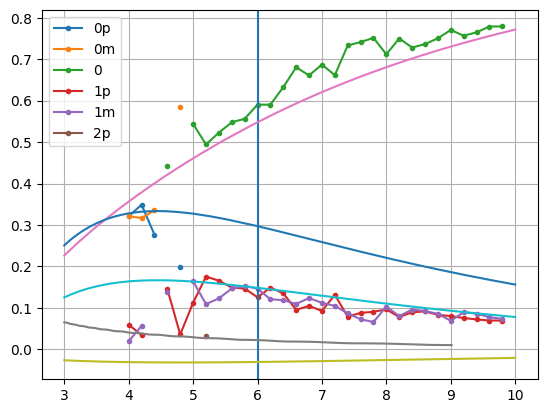

In [699]:
df_r.plot(style='.-')
plt.grid()
plt.axvline(6.)
plt.plot(Ks_,F_R0u(Ks_))
plt.plot(Ks_,F_R0d(Ks_))

plt.plot(Ks_,(F_RMu(Ks_) - F_R0u(Ks_))/2)
plt.plot(Ks_,r_su_l)
plt.plot(Ks_,r_su_l*2)


In [623]:
a[(a['Group']==0)&(a['g sign']==0)]

,group #,group rot,Group,g sign,r_m,r_std
0,367,-0.012569,0.0,-0.0,0.731256,0.000683


In [597]:
for K,a in zip(Ks,K_f):
    print(K)
    print(a)

0.0
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
0.2
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
0.4
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
0.6
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
0.8
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
1.0
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
1.2
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
1.4
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
1.6
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
1.8
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
2.0
Empty DataFrame
Columns: [group #, group rot, Group, g sign, r_m, r_std]
Index: []
2.2
Empty DataFrame
Columns: [group #, grou